### Import the data

In [893]:
#Import the train and test dataset
import pandas as pd

data = pd.read_csv('train.csv')

breed = pd.read_csv('breed_labels.csv')
state = pd.read_csv('state_labels.csv')
color = pd.read_csv('color_labels.csv')

#There are two type of pets (dog=1, cat=2), we only consider the dog in this dataset, drop the cats data
print(len(data[data.Type == 2]),"rows have been removed.")
data.drop(data[data.Type == 2].index, inplace=True)
data = data.drop('Type', axis = 1)

print(data.head())

6861 rows have been removed.
                       Name  Age  Breed1  Breed2  Gender  Color1  Color2  \
2                    Brisco    1     307       0       1       2       7   
3                      Miko    4     307       0       2       1       2   
4                    Hunter    1     307       0       1       1       0   
7   Siu Pak & Her 6 Puppies    0     307       0       2       1       2   
10                     Bear    2     307       0       1       1       2   

    Color3  MaturitySize  FurLength  ...  Health  Quantity  Fee  State  \
2        0             2          2  ...       1         1    0  41326   
3        0             2          1  ...       1         1  150  41401   
4        0             2          1  ...       1         1    0  41326   
7        7             2          1  ...       1         6    0  41326   
10       7             2          1  ...       1         1    0  41401   

                           RescuerID  VideoAmt  \
2   fa90fa5b1ee11c8

### Exploring the Tabular dataset

In [894]:
print("The shape of the whole set:",data.shape)
print("")
print("The columns name: ",list(data.columns))

The shape of the whole set: (8132, 23)

The columns name:  ['Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID', 'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed']


#### Target Variable: AdoptionSpeed

- 0 - Pet was adopted on the same day as it was listed.
- 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
- 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
- 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
- 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

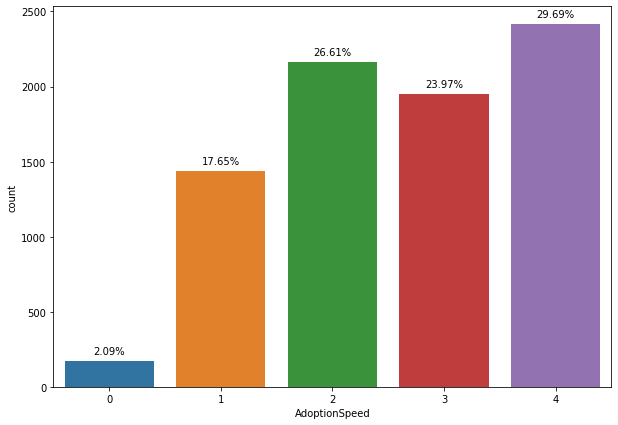

In [895]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7));
g = sns.countplot(x='AdoptionSpeed', data = data)
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / data.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=10, color='black',  xytext=(0, 10),
         textcoords='offset points') 

From the graph, we can see that only a few dog (2.09%) are adopted immediately. Most of the dogs are adopted within one month (17.65% + 26.61%), unfortunately about 30% pets have been adopted yet.

#### PetID - Unique HashID for pet profile

In [896]:
print(data['PetID'].head())

#Not useful in the model, drop
data = data.drop('PetID',axis = 1)
data.shape

2     3422e4906
3     5842f1ff5
4     850a43f90
7     97aa9eeac
10    8b693ca84
Name: PetID, dtype: object


(8132, 22)

#### Name - Name of pet

In [897]:
print("There are",data.Name.isnull().sum(),"null values in Name column.")
name_series = data['Name'].value_counts()
print("There are",len(name_series),"unique names in Name column.\n")
print("Top 5 popular dog name:")
print(name_series.head())

There are 649 null values in Name column.
There are 5042 unique names in Name column.

Top 5 popular dog name:
Lucky      48
Puppy      45
Brownie    44
Max        35
Baby       32
Name: Name, dtype: int64


In [898]:
data['Have_Name'] = 1
data.loc[data.Name.isnull(),'Have_Name'] =0
data.loc[data.Name=='No Name Yet','Have_Name'] =0

name_crosstab = pd.crosstab(data['AdoptionSpeed'],data['Have_Name'])
name_crosstab

Have_Name,0,1
AdoptionSpeed,,
0,15,155
1,125,1310
2,157,2007
3,102,1847
4,258,2156


In [899]:
from scipy.stats import chi2_contingency

name_crosstab = pd.crosstab(data['AdoptionSpeed'],data['Have_Name'])
chi_val, p_val, dof, expected =  chi2_contingency(name_crosstab)
print("P-value of chi-square test:",p_val)
#p-value <0.05, Reject the null hypothesis that Type and AdoptionSpeed is independent

P-value of chi-square test: 2.188348676518212e-09


Chi-Square Test between Have_Name and AdoptionSpeed <= 0.05, we reject the H0 (they are independent). As they are related, instead of using their name as attribute, we use the categorical variable - Have_Name and drop Name attribute.

In [900]:
#Too many empty value, textual variable is hard to process, drop this column
data = data.drop('Name',axis = 1)
data.shape

(8132, 22)

#### Age - age of pet

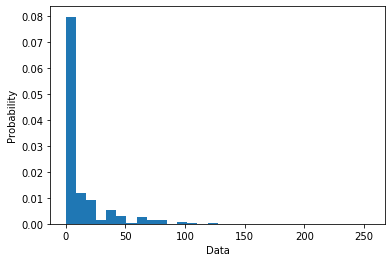

In [901]:
import matplotlib.pyplot as plt

plt.hist(data['Age'], density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [902]:
print("There are total",len(data),"pets,",round(len(data[data.Age<=30])/len(data),4),"of them are < 30 year olds.\n")


#Drop the row bigger than 30 years old, not in line with commen sense.
print(len(data[data.Age> 30]),"rows have been removed.")
data.drop(data[data.Age > 30].index, inplace=True)
print(data.shape)

There are total 8132 pets, 0.8634 of them are < 30 year olds.

1111 rows have been removed.
(7021, 22)


In [903]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [904]:
import plotly.graph_objs as go

tmp = []
for i in range(5):
    df = data.loc[data['AdoptionSpeed'] == i]

    tmp.append(go.Scatter(
        x = df['Age'].value_counts().sort_index().index,
        y = df['Age'].value_counts().sort_index().values,
        name = str(i)
    ))
    
layout = go.Layout(dict(title = "AdoptionSpeed trends by Age",
                  xaxis = dict(title = 'Age (months)'),
                  yaxis = dict(title = 'Counts'),
                  )
                  )
py.iplot(dict(data=tmp, layout=layout), filename='basic-line')

From graph, we can conclude that pets with younger age are more likely to be adopted.

#### Breeds - Breed 1: main breed, Breed 2: secondary breed if not pure

In [905]:
breed_dic = {k: v for k, v in zip(breed['BreedID'], breed['BreedName'])}
data['Breed1Name'] = data['Breed1'].apply(lambda x: breed_dic[x] if x in breed_dic else 'Unknown')
data['Breed2Name'] = data['Breed2'].apply(lambda x: breed_dic[x] if x in breed_dic else 'Unknown')

main_breed_series = data['Breed1Name'].value_counts()
second_breed_series = data['Breed2Name'].value_counts()
print(main_breed_series.head(10),'\n')
print(second_breed_series.head(10))

Mixed Breed            5591
Labrador Retriever      165
Terrier                 133
Poodle                   94
Golden Retriever         74
Shih Tzu                 71
German Shepherd Dog      69
Spitz                    63
Rottweiler               58
Doberman Pinscher        49
Name: Breed1Name, dtype: int64 

Unknown                4785
Mixed Breed            1598
Labrador Retriever       76
Terrier                  75
German Shepherd Dog      51
Spitz                    39
Rottweiler               38
Golden Retriever         34
Poodle                   22
Doberman Pinscher        22
Name: Breed2Name, dtype: int64


Text(0.5, 1.0, 'Pure breed of pet')

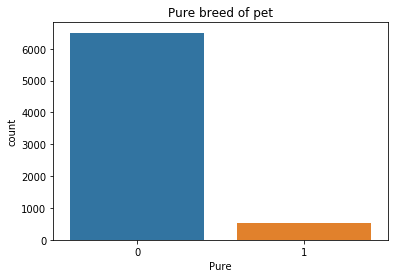

In [906]:
data['Pure'] = 0
data.loc[(data.Breed1Name != 'Mixed Breed')&(data.Breed2==0),'Pure'] = 1

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data.Pure)
plt.title("Pure breed of pet")

In [907]:
import pandas as pd
from scipy.stats import chi2_contingency

pure_crosstab = pd.crosstab(data['AdoptionSpeed'],data['Pure'], normalize = 'index')
print(pure_crosstab)
chi_val, p_val, dof, expected =  chi2_contingency(pure_crosstab)
print("P-value of chi-square test:",p_val)

Pure                  0         1
AdoptionSpeed                    
0              0.780142  0.219858
1              0.840486  0.159514
2              0.932354  0.067646
3              0.942408  0.057592
4              0.970282  0.029718
P-value of chi-square test: 0.9918599924746639


From the cross-table and X2 test, we can conclude that the pure dog have a higher adoption speed. So instead of using its breed, we use the Pure attribute.

In [908]:
data = data.drop('Breed1',axis = 1)
data = data.drop('Breed2',axis = 1)
data = data.drop('Breed1Name',axis = 1)
data = data.drop('Breed2Name',axis = 1)
data.shape

(7021, 21)

#### Gender - male: 1, female:2, mixed: 3

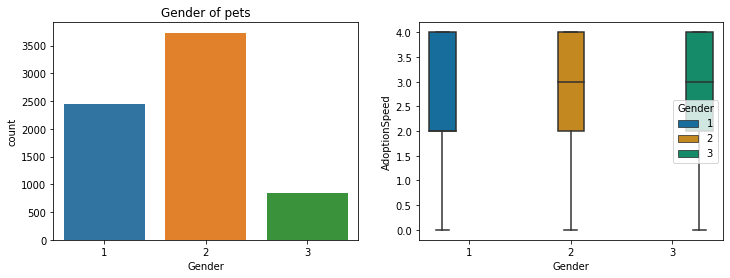

In [909]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4));
plt.subplot(1, 2, 1)
sns.countplot(data.Gender)
plt.title("Gender of pets")


plt.subplot(1, 2, 2)
sns.boxplot(y='AdoptionSpeed', x='Gender', 
                 data=data, 
                 palette="colorblind",
                 hue='Gender')

In [910]:
result = data.groupby('Gender').agg({'AdoptionSpeed': ['count','mean', 'median',pd.Series.mode]})
result

AdoptionSpeed                      
               count      mean median mode
Gender                                    
1               2448  2.459150      2    2
2               3731  2.669794      3    4
3                842  2.732779      3    4

From the graph, more than half of dogs are femalre, however male pets have a higher adoption_speed compared with female and mixed gender.

#### Color - Color1, Color2, Color3 of pets

In [911]:
color_dic= {k: v for k, v in zip(color['ColorID'], color['ColorName'])}

data['Color1_Name'] = data['Color1'].apply(lambda x: color_dic[x] if x in color_dic else 'Unknown')
data['Color2_Name'] = data['Color2'].apply(lambda x: color_dic[x] if x in color_dic else 'Unknown')
data['Color3_Name'] = data['Color3'].apply(lambda x: color_dic[x] if x in color_dic else 'Unknown')

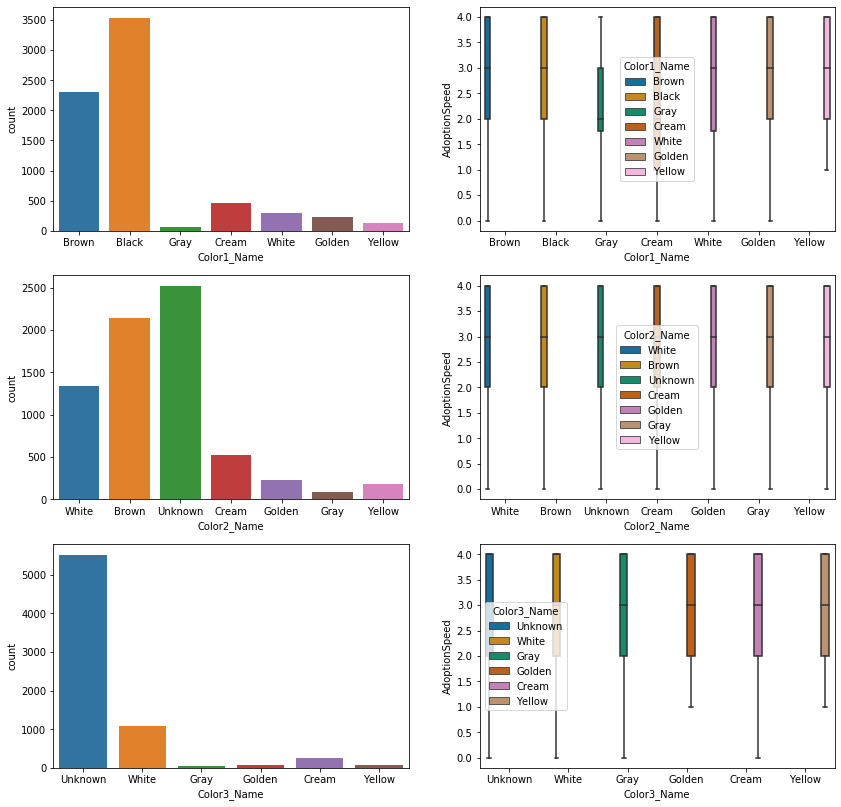

In [912]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(14, 14));

plt.subplot(3, 2, 1)
sns.countplot(data.Color1_Name)

plt.subplot(3, 2, 2)
sns.boxplot(y='AdoptionSpeed', x='Color1_Name', 
                 data=data, 
                 palette="colorblind",
                 hue='Color1_Name')

plt.subplot(3, 2, 3)
sns.countplot(data.Color2_Name)

plt.subplot(3, 2, 4)
sns.boxplot(y='AdoptionSpeed', x='Color2_Name', 
                 data=data, 
                 palette="colorblind",
                 hue='Color2_Name') 


plt.subplot(3, 2, 5)
sns.countplot(data.Color3_Name)


plt.subplot(3, 2, 6)
sns.boxplot(y='AdoptionSpeed', x='Color3_Name', 
                 data=data, 
                 palette="colorblind",
                 hue='Color3_Name') 

Seems that different color have different impact on adoption speed, try to investigate on how many color does dog have.

In [913]:
data['Color_num'] = 3
data.loc[data.Color3_Name == 'Unknown','Color_num'] = 2
data.loc[data.Color2_Name == 'Unknown','Color_num'] = 1

result = data.groupby('Color_num').agg({'AdoptionSpeed': ['count','mean', 'median',pd.Series.mode]})
result

AdoptionSpeed                      
                  count      mean median mode
Color_num                                    
1                  2520  2.637698      3    4
2                  2996  2.564753      3    2
3                  1505  2.625249      3    4

Seems that dog with 2-color have a slightly higher adoption speed, maybe investigate on first color.

In [914]:
result1 = data.groupby('Color1_Name').agg({'AdoptionSpeed': ['count','mean', 'median',pd.Series.mode]})
result2 = data.groupby('Color2_Name').agg({'AdoptionSpeed': ['count','mean', 'median',pd.Series.mode]})
result3 = data.groupby('Color3_Name').agg({'AdoptionSpeed': ['count','mean', 'median',pd.Series.mode]})

print(result1)
print(result2)
print(result3)

            AdoptionSpeed                      
                    count      mean median mode
Color1_Name                                    
Black                3542  2.581875      3    2
Brown                2311  2.668109      3    4
Cream                 466  2.452790      2    4
Golden                230  2.556522      3    4
Gray                   56  2.375000      2    2
White                 288  2.517361      3    4
Yellow                128  2.984375      3    4
            AdoptionSpeed                      
                    count      mean median mode
Color2_Name                                    
Brown                2144  2.569030      3    2
Cream                 518  2.592664      3    2
Golden                233  2.682403      3    4
Gray                   83  2.578313      3    4
Unknown              2520  2.637698      3    4
White                1339  2.575056      3    4
Yellow                184  2.701087      3    4
            AdoptionSpeed               

In [915]:
data['All_color'] = (data['Color1_Name'] + '__' + data['Color2_Name'] + '__' + data['Color3_Name']).str.replace('__', '')
result = data.groupby('All_color').agg({'AdoptionSpeed': ['count','mean', 'median']})
result.head()

AdoptionSpeed                 
                          count      mean median
All_color                                       
BlackBrownCream             183  2.579235    3.0
BlackBrownGolden             79  2.632911    3.0
BlackBrownGray               25  2.600000    2.0
BlackBrownUnknown          1127  2.550133    3.0
BlackBrownWhite             677  2.548006    3.0

In [916]:
data = data.drop('Color1',axis = 1)
data = data.drop('Color2',axis = 1)
data = data.drop('Color3',axis = 1)
data.shape

(7021, 23)

#### Quantity -- number of pets represented in the file

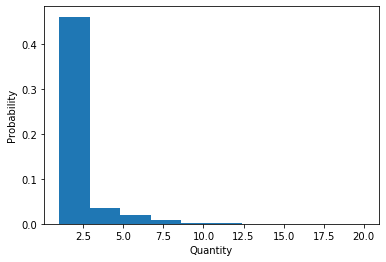

In [917]:
plt.hist(data['Quantity'], density=True, bins=10)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Quantity');

In [918]:
result = data.groupby('Quantity').agg({'AdoptionSpeed': ['count','mean', 'median']})
result

AdoptionSpeed                 
                 count      mean median
Quantity                               
1                 5593  2.566422      3
2                  544  2.648897      3
3                  253  2.719368      3
4                  205  2.834146      3
5                  145  2.937931      3
6                  117  2.820513      3
7                   57  2.877193      3
8                   45  2.622222      3
9                   29  2.689655      3
10                   6  3.000000      3
11                   7  3.000000      3
12                   4  3.000000      3
13                   1  2.000000      2
14                   1  4.000000      4
15                   1  4.000000      4
16                   2  3.000000      3
17                   3  2.333333      2
20                   8  3.500000      4

Most of the pets'quantity is less than or equal to 10, we only consider the <=10 cases.

In [919]:
print(len(data[data.Quantity > 10]),"rows have been removed.")
data.drop(data[data.Quantity > 10].index, inplace=True)
print(data.shape)

27 rows have been removed.
(6994, 23)




#### Apperance of Pets  - MaturitySize (1=Small, 2 = Medium, 3 =  Large, 4= Extra Large, 5 = Not specified), FurLength(1=Short, 2 = Medium, 3=Long, 0=Not Specified)

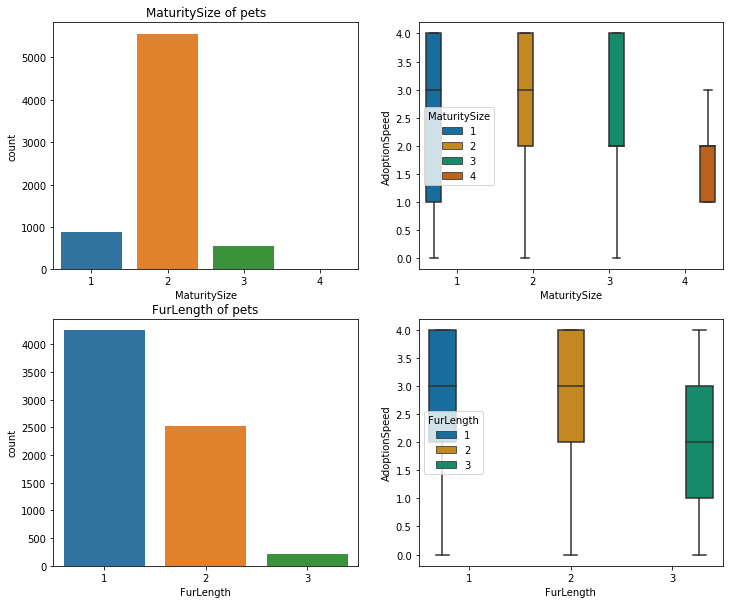

In [920]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10));
plt.subplot(2, 2, 1)
sns.countplot(data.MaturitySize)
plt.title("MaturitySize of pets")


plt.subplot(2, 2, 2)
sns.boxplot(y='AdoptionSpeed', x='MaturitySize', 
                 data=data, 
                 palette="colorblind",
                 hue='MaturitySize') 

plt.subplot(2, 2, 3)
sns.countplot(data.FurLength)
plt.title("FurLength of pets")


plt.subplot(2, 2, 4)
sns.boxplot(y='AdoptionSpeed', x='FurLength', 
                 data=data, 
                 palette="colorblind",
                 hue='FurLength') 

- No pets haven't specified in two attributes. 
- Most of the pets are medium MaturitySize and short length, for some reason, unspecified dogs in these two attributes are prefered. 

#### Health  - Health Condition (1=Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not specified)

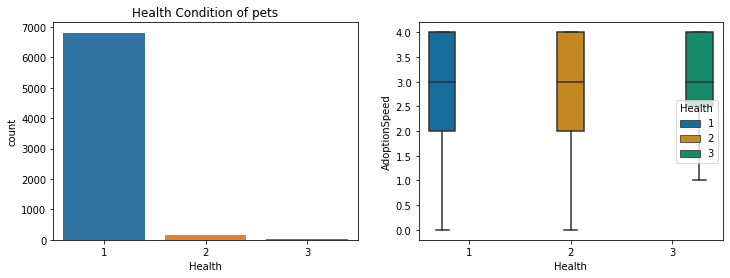

In [921]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4));
plt.subplot(1, 2, 1)
sns.countplot(data.Health)
plt.title("Health Condition of pets")


plt.subplot(1, 2, 2)
sns.boxplot(y='AdoptionSpeed', x='Health', 
                 data=data, 
                 palette="colorblind",
                 hue='Health') 

Every pets have health condition attribute, no 0 value.
Most pets are healthy, from the box plot, health condition have a small influence on adoption speed. 

#### Health Related - Vaccinated (1=Yes, 2=No, 3=Not sure), Dewormed(1=Yes, 2=No, 3=Not sure),Sterilized(1=Yes, 2=No, 3=Not sure)

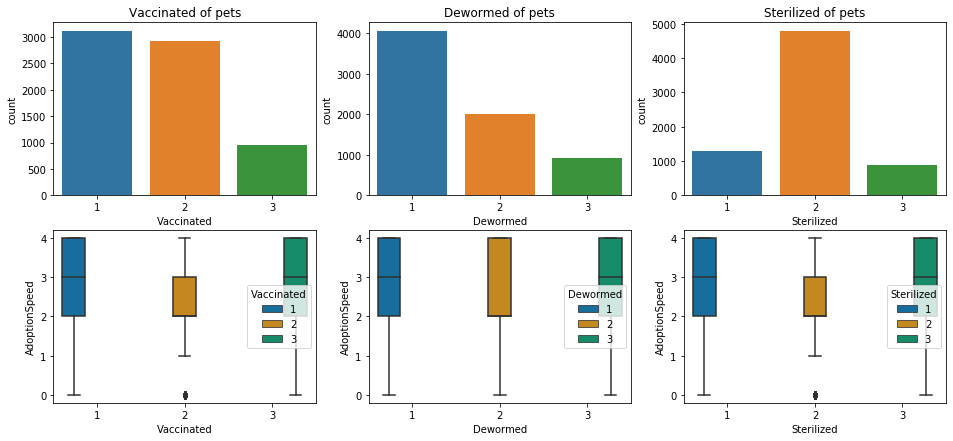

In [922]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(16, 7));

plt.subplot(2, 3, 1)
sns.countplot(data.Vaccinated)
plt.title("Vaccinated of pets")

plt.subplot(2, 3, 2)
sns.countplot(data.Dewormed)
plt.title("Dewormed of pets")

plt.subplot(2, 3, 3)
sns.countplot(data.Sterilized)
plt.title("Sterilized of pets")

plt.subplot(2, 3, 4)
sns.boxplot(y='AdoptionSpeed', x='Vaccinated', 
                 data=data, 
                 palette="colorblind",
                 hue='Vaccinated')

plt.subplot(2, 3, 5)
sns.boxplot(y='AdoptionSpeed', x='Dewormed', 
                 data=data, 
                 palette="colorblind",
                 hue='Dewormed') 

plt.subplot(2, 3, 6)
sns.boxplot(y='AdoptionSpeed', x='Sterilized', 
                 data=data, 
                 palette="colorblind",
                 hue='Sterilized') 

- About 50% of dog have vaccinated, and vaccinated pets have higher adoption speed.
- Most pets are dewormed, the pets dewored/unkown have higher adoption speed.
- Most pets haven't been sterilized, and unsterilized pets have higher adoption speed.

#### Fee - Adoption fee (0=free)

0      6046
50      152
100     127
200     108
20       97
Name: Fee, dtype: int64


Text(0.5, 1.0, 'Histogram of adoption fee')

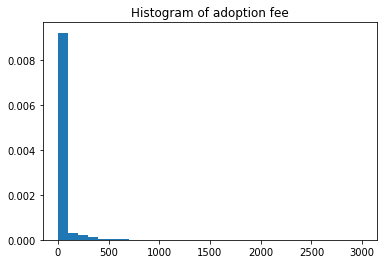

In [923]:
fee_series = data['Fee'].value_counts()
print(fee_series.head())

plt.hist(data['Fee'], density=True, bins=30)
plt.title("Histogram of adoption fee")

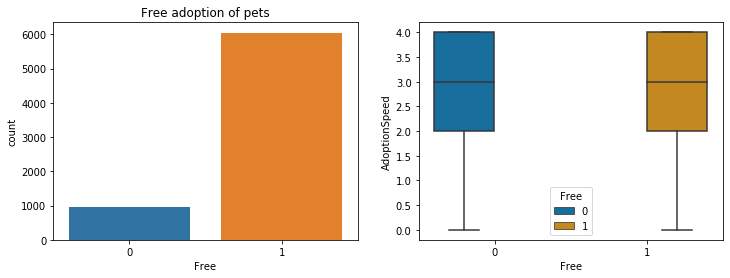

In [924]:
data['Free'] = 0
data.loc[data.Fee==0 ,'Free'] = 1

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4));
plt.subplot(1, 2, 1)
sns.countplot(data.Free)
plt.title("Free adoption of pets")


plt.subplot(1, 2, 2)
sns.boxplot(y='AdoptionSpeed', x='Free', 
                 data=data, 
                 palette="colorblind",
                 hue='Free') 

Most pets are free adoption, patterns look same in two group.. Drop fee or not?

#### State - State Location in Malaysia

In [925]:
print("There are",data.State.isnull().sum(),"null values in State column.")

state_dic = {k: v for k, v in zip(state['StateID'], state['StateName'])}
data['StateName'] = data['State'].apply(lambda x: state_dic[x] if x in state_dic else 'Unknown')
rescureID_series = data['StateName'].value_counts()
rescureID_series

There are 0 null values in State column.


Selangor           4226
Kuala Lumpur       1400
Pulau Pinang        550
Perak               292
Johor               239
Negeri Sembilan     123
Melaka               74
Kedah                48
Pahang               29
Sabah                 4
Kelantan              3
Terengganu            2
Sarawak               2
Labuan                2
Name: StateName, dtype: int64

In [926]:
result = data.groupby('StateName').agg({'AdoptionSpeed': ['count','mean', 'median']})
result

#Give marks?

AdoptionSpeed                 
                        count      mean median
StateName                                     
Johor                     239  2.397490    2.0
Kedah                      48  2.666667    3.0
Kelantan                    3  2.666667    4.0
Kuala Lumpur             1400  2.622857    3.0
Labuan                      2  2.500000    2.5
Melaka                     74  3.229730    4.0
Negeri Sembilan           123  3.170732    4.0
Pahang                     29  2.413793    2.0
Perak                     292  2.732877    3.0
Pulau Pinang              550  2.796364    3.0
Sabah                       4  1.750000    2.0
Sarawak                     2  2.500000    2.5
Selangor                 4226  2.546143    3.0
Terengganu                  2  2.500000    2.5

From the table, the adoption situation in different state is quite different. In many stats, most pets haven't been adopted.

In [927]:
data = data.drop('State',axis = 1)

#### RescuerID - Unique hash ID of rescuer

In [928]:
rescureID_series = data['RescuerID'].value_counts()
rescureID_series.head()

fa90fa5b1ee11c86938398b60abc32cb    444
aa66486163b6cbc25ea62a34b11c9b91    235
b53c34474d9e24574bcec6a3d3306a0d    221
c00756f2bdd8fa88fc9f07a8309f7d5d    152
ee2747ce26468ec44c7194e7d1d9dad9    134
Name: RescuerID, dtype: int64

In [929]:
#Difficult to analyze this column, drop
data = data.drop('RescuerID',axis = 1)
data.shape

(6994, 23)

#### VideoAmt, PhotoAmt - Video & Photo of pets

In [930]:
video_series = data['VideoAmt'].value_counts()
photo_series = data['PhotoAmt'].value_counts()
print(video_series.head(),'\n') #Most pets do not have videos
print(photo_series.head(10)) #Most pets have 1-5 photos, only a few pets dont have photo

0    6709
1     206
2      40
3      22
4      10
Name: VideoAmt, dtype: int64 

1.0    1582
2.0    1216
3.0    1098
5.0     928
4.0     821
6.0     292
7.0     201
8.0     165
0.0     147
9.0     104
Name: PhotoAmt, dtype: int64


In [931]:
#Most pets do not have video, drop this column
data = data.drop('VideoAmt',axis = 1)
data.shape

(6994, 22)

In [932]:
from scipy.stats import f_oneway

CategoryGroupLists= data.groupby('PhotoAmt')['AdoptionSpeed'].apply(list)
# Performing the ANOVA test
# We accept the Assumption(H0: PhotoAmt and AdoptionSpeed is not related) only when P-Value bigger 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
print('P-Value for Anova is: ', AnovaResults[1])
#P-value <0.05, PhotoAmt is related with AdoptionSpeed

P-Value for Anova is:  0.24076217346119408


#### Description - profile of pets, written in English, Malay or Chinese

In [933]:
print("There are",data.Description.isnull().sum(),"null values in Description column.")
#We don't investigate the textual information, drop description attribute
data = data.drop('Description',axis = 1)
data.shape

There are 2 null values in Description column.


(6994, 21)

## Classification Algorithm

In [934]:
data.columns

Index(['Age', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'PhotoAmt', 'AdoptionSpeed',
       'Have_Name', 'Pure', 'Color1_Name', 'Color2_Name', 'Color3_Name',
       'Color_num', 'All_color', 'Free', 'StateName'],
      dtype='object')

- Target attribution: AdoptionSpeed (categorical)


- Indepednet variables:
- Numerical: Age: 1-30, Quantity: 1-10, color_num = 1-3, PhotoAmt: 0-30, Fee
- Text: StateName,Color1Name,Color2Name,Color3Name,All_color
- Categorical: Age, Gender, MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Have_name,Pure,Free

#### Train and Test set split

In [935]:
from sklearn.model_selection import train_test_split

y = data['AdoptionSpeed']
X = data.drop('AdoptionSpeed',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Train set shape (no label column):", X_train.shape)
print("Test set shape (no label column):", X_test.shape)

Train set shape (no label column): (5595, 20)
Test set shape (no label column): (1399, 20)
